# Instance Segmentation with Berlin DOP, 10 cm resolution. The annotations are in COCO format


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# # install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.8 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# # opencv is pre-installed on colab

In [ ]:
# import os
# p = os.getenv('PATH')
# ld = os.getenv('LD_LIBRARY_PATH')
# os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
# os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"

In [ ]:
# !pip install -U torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# # install dependencies: 
# !pip install pyyaml==5.1
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version
# # # opencv is pre-installed on colab

# # # install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# # # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# # import torch
# # assert torch.__version__.startswith("1.5")   # need to manually install torch 1.8 if Colab changes its default version
# # !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
!nvidia-RAM


/bin/bash: nvidia-RAM: command not found


In [ ]:
!cat /proc/meminfo

MemTotal:       26696420 kB
MemFree:         5015728 kB
MemAvailable:   25280104 kB
Buffers:          149484 kB
Cached:         19872204 kB
SwapCached:            0 kB
Active:          2312168 kB
Inactive:       18652944 kB
Active(anon):     784620 kB
Inactive(anon):      524 kB
Active(file):    1527548 kB
Inactive(file): 18652420 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1176 kB
Writeback:             0 kB
AnonPages:        943480 kB
Mapped:          1043556 kB
Shmem:              1196 kB
KReclaimable:     501896 kB
Slab:             573900 kB
SReclaimable:     501896 kB
SUnreclaim:        72004 kB
KernelStack:        6704 kB
PageTables:        11088 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13348208 kB
Committed_AS:    4662876 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       49672 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 29 20:36:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#import torch
#assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
#!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

## Get data

In [ ]:
# check CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
import torch
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu111 True


In [ ]:
!ls -d /usr/local/cuda-*

/usr/local/cuda-10.0  /usr/local/cuda-11    /usr/local/cuda-11.1
/usr/local/cuda-10.1  /usr/local/cuda-11.0


In [ ]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

Importing data

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Train_annotations.json", "/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Train")
register_coco_instances("my_dataset_valid", {}, "/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Valid_annotations.json", "/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Valid")
register_coco_instances("my_dataset_test", {}, "", "/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Test")

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

WARNING [01/29 20:45:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/29 20:45:02 d2.data.datasets.coco]: Loaded 356 images in COCO format from /content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Train_annotations.json


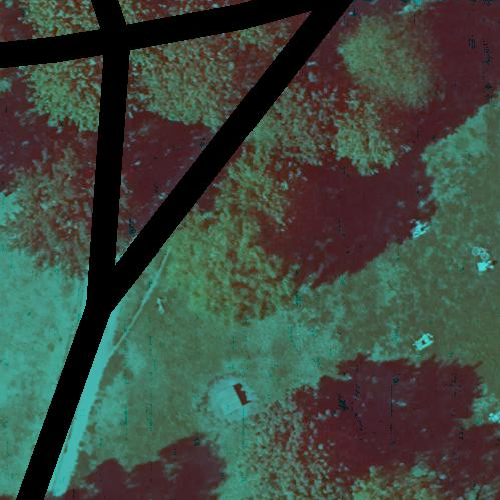

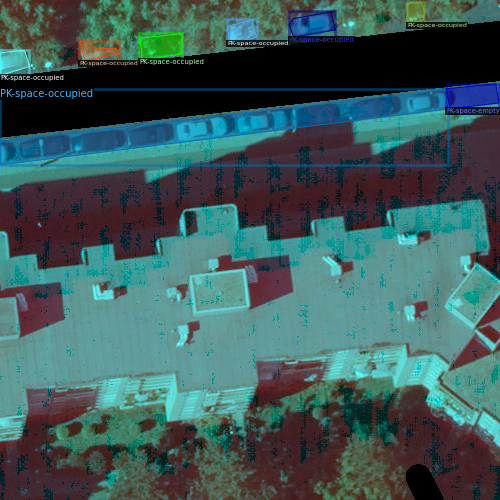

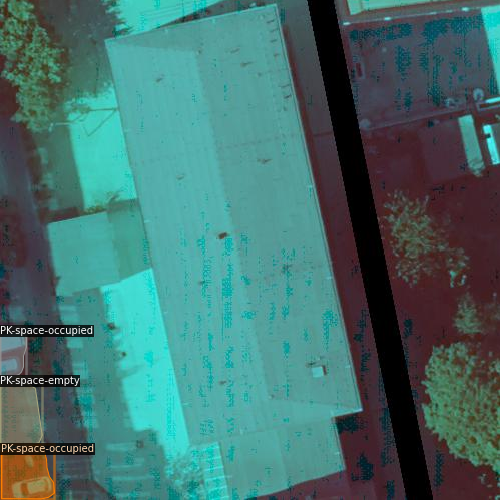

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 700
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[01/29 20:45:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:09, 19.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[01/29 20:45:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[01/29 20:45:52 d2.utils.events]:  eta: 0:08:11  iter: 19  total_loss: 2.604  loss_cls: 1.28  loss_box_reg: 0.08296  loss_mask: 0.6924  loss_rpn_cls: 0.5233  loss_rpn_loc: 0.07049  time: 0.7348  data_time: 0.5160  lr: 7.0289e-05  max_mem: 1862M
[01/29 20:46:06 d2.utils.events]:  eta: 0:07:56  iter: 39  total_loss: 1.525  loss_cls: 0.3763  loss_box_reg: 0.09026  loss_mask: 0.6808  loss_rpn_cls: 0.2531  loss_rpn_loc: 0.04226  time: 0.7251  data_time: 0.4855  lr: 0.00014165  max_mem: 1862M
[01/29 20:46:20 d2.utils.events]:  eta: 0:07:40  iter: 59  total_loss: 1.185  loss_cls: 0.2355  loss_box_reg: 0.1478  loss_mask: 0.6425  loss_rpn_cls: 0.1441  loss_rpn_loc: 0.0297  time: 0.7216  data_time: 0.4780  lr: 0.000213  max_mem: 1997M
[01/29 20:46:35 d2.utils.events]:  eta: 0:07:25  iter: 79  total_loss: 1.321  loss_cls: 0.2777  loss_box_reg: 0.1855  loss_mask: 0.5992  loss_rpn_cls: 0.1673  loss_rpn_loc: 0.04721  time: 0.7197  data_time: 0.4669  lr: 0.00028436  max_mem: 2475M
[01/29 20:46:49 d2.

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [ ]:
# DatasetCatalog.clear()
# MetadataCatalog.clear()

In [ ]:
# Evaluation
test_metadata = MetadataCatalog.get("my_dataset_valid")
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_valid", )
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_valid", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_valid")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/29 20:49:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/29 20:49:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/29 20:49:43 d2.data.datasets.coco]: Loaded 153 images in COCO format from /content/drive/MyDrive/Berlin DOP 2020 10cm RGL/Valid_annotations.json
[01/29 20:49:43 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|
| PK-space-em.. | 151          | PK-space-oc.. | 381          |
|               |              |               |              |
|     total     | 532          |               |              |
[01/29 20:49:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), m

OrderedDict([('bbox',
              {'AP': 20.610188525076975,
               'AP-PK-space-empty': 13.952642126713341,
               'AP-PK-space-occupied': 27.267734923440614,
               'AP50': 46.199334177708984,
               'AP75': 15.939093581211136,
               'APl': 12.818780566179136,
               'APm': 24.9472919908958,
               'APs': 17.744303661038746}),
             ('segm',
              {'AP': 19.999416933461127,
               'AP-PK-space-empty': 13.967609069582643,
               'AP-PK-space-occupied': 26.031224797339608,
               'AP50': 45.23113977709964,
               'AP75': 15.934868972676819,
               'APl': 31.350465928945837,
               'APm': 25.838827304993494,
               'APs': 9.688080001653883})])

In [ ]:
# Printing the names of the categories
for i, name in enumerate(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes):
    print(i, name)

In [12]:
# from detectron2.utils.visualizer import ColorMode
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import glob
import json
import numpy as np
from pycocotools import mask
from skimage import measure
import base64
import cv2

# Saving the predictions in lebelme format

In [13]:

for imageName in glob.glob('/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/For matrices/*.jpeg'):
  
#for d in dataset_dicts:
  im = cv2.imread(imageName)
  outputs = predictor(im)
  masks = outputs['instances'].pred_masks.cpu().numpy()
  categories = outputs['instances'].pred_classes.cpu().numpy()
  encoded = base64.b64encode(open(imageName, "rb").read())
  number_of_masks = masks.shape[0]
  file_name_1 = imageName.replace("/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/For matrices/","")
  file_name_2 = file_name_1.replace(".jpeg","")
  file_name_3 = file_name_2 + ".json"
  file_name_4 = str("/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/New Folder/") + str(file_name_3)
  #print(file_name_1, file_name_2, file_name_3, file_name_4)
  main_annotation = {}
  main_annotation['shapes'] = []


  # Iterating for all masks. Every mask has one contour and a category relevant for that
  for x in range(0, number_of_masks):
    # Selecting relevant mask. Number of masks == number of categories
    ground_truth_binary_mask = masks[x,:,:]
    category = categories[x]
    if category == 0:
      cat = "PK-space-empty"
    else:
      cat = "PK-space-occupied"
    #fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    #contours = measure.approximate_polygon(ground_truth_binary_mask, 0.5)
    contours = measure.find_contours(ground_truth_binary_mask, 0.5)
    app_con = measure.approximate_polygon(np.array(contours[0]), tolerance=0.8)

    annotation = {
          "label" : cat,
          #"points": np.flip(contours[0], axis=1).tolist(),
          "points": np.flip(app_con, axis=1).tolist(),
          "group_id": None,
          "shape_type": "polygon",
          "flags": {}}

    main_annotation['shapes'].append(annotation)

  main_annotation["imagePath"] = file_name_1
  main_annotation["imageData"] = str(encoded)[2:-1]
  main_annotation["imageHeight"] = 512
  main_annotation["imageWidth"] = 512
  #print(main_annotation)
  # print(json.dumps(annotation, indent=4,  separators=(',', ':',)))
  with open(file_name_4, 'w') as file:
    json.dump(main_annotation, file,indent=4,  separators=(',', ':',))

  # v = Visualizer(im[:, :, ::-1],
  #                 metadata=test_metadata, 
  #                 scale=1, 
  #                 #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
  # )
  # v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # cv2_imshow(v.get_image()[:, :, ::-1])

  # f = open("/content/drive/MyDrive/Cowc for detectrone2 test/COWC_PKLot_Predictions.txt","a")
  # f.write(str(d["file_name"]) +"\n" + str(outputs["instances"])+"\n")
  # f.close()
  # break
  # break

# Visualising the predictions

In [ ]:
#DatasetCatalog.clear()
#MetadataCatalog.clear()

In [ ]:
#register_coco_instances("my_dataset_test2", {}, "/content/drive/MyDrive/Berlin DOP 2020 10cm/Test_annotations.json", "/content/drive/MyDrive/Berlin DOP 2020 10cm/Test")

In [15]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in random.sample(glob.glob('/content/drive/MyDrive/Berlin DOP 2020 10cm RGL/For matrices/*.jpeg'),15):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=1
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.